#<h3><b>Install Imporant Libraries</h3>

In [ ]:
!pip install obspy


  Using cached pywavelets-1.7.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (9.0 kB)
Using cached pywavelets-1.7.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.5 MB)


In [ ]:
!pip install pywavelets

<h3><b>Import Libraries</h3>

In [ ]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os
from scipy import signal
from matplotlib import cm
import numpy as np
import matplotlib.pyplot as plt
import pywt
from scipy.ndimage import gaussian_filter1d

<h3><b>Load Miniseed data</h3>

         network: XB
         station: ELYSE
        location: 02
         channel: BHV
       starttime: 2019-09-21T03:00:00.037000Z
         endtime: 2019-09-21T03:59:59.987000Z
   sampling_rate: 20.0
           delta: 0.05
            npts: 72000
           calib: 1.0
         _format: MSEED
           mseed: AttribDict({'dataquality': 'D', 'number_of_records': 143, 'encoding': 'FLOAT64', 'byteorder': '>', 'record_length': 4096, 'filesize': 585728})


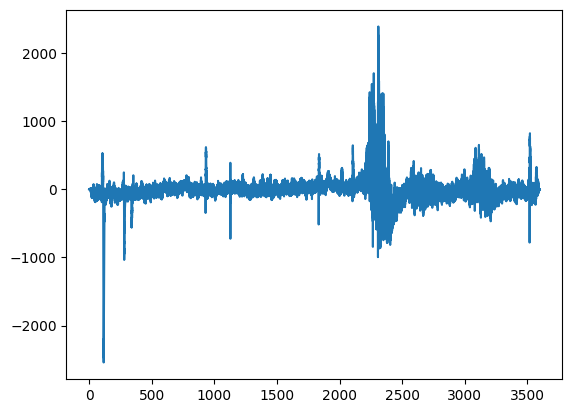

In [138]:
st=read('/content/XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed')
filename='XB.ELYSE.02.BHV.2019-09-21HR03_evid0032.mseed'
print(st[0].stats)
tr=st[0]
tr_data=tr.data
tr_times=tr.times()
plt.plot(tr.times(),tr.data)
plt.show()

<h3><b>Fliter data   </h3>
Nyquist Sampling<br>
bandpassfilter

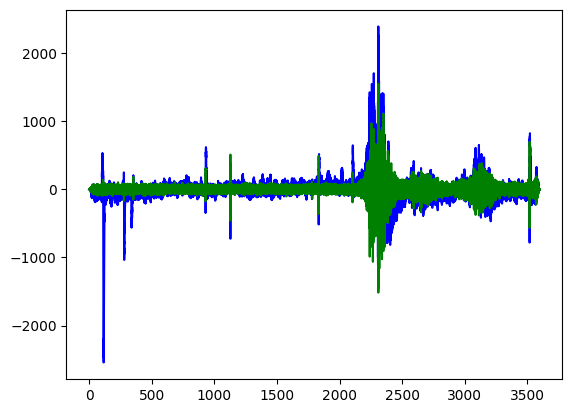

In [139]:
# Set the minimum frequency
minfreq = 1
maxfreq = (tr.stats.sampling_rate/2)-1


# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data

tr_filt.stats.sampling_rate
plt.plot(tr.times(),tr_data,c='blue')
plt.plot(tr_filt.times(),tr_data_filt,c='green')
plt.show()

<h3><b>Perform Continuous Wavelet Transform (CWT) on the filtered signal<h3>

In [140]:

scales = np.arange(1, int(tr.stats.sampling_rate))  # Here we are going with the given sampling rate to capture wavelet at most accurate signal time

wavelet = 'cmor1-1.5'  # The bandwidth parameter affects the time-frequency resolution of the wavelet


coefficients, frequencies = pywt.cwt(tr_data_filt, scales, wavelet)#Compute the continuous wavelet transform (CWT)

# Sum the magnitudes of the wavelet coefficients across all scales for each time point
summed_coefficients = np.sum(np.abs(coefficients), axis=0)

# Apply a Gaussian filter to smooth the summed coefficients
smoothed_summed_coefficients = gaussian_filter1d(summed_coefficients, sigma=5)#helps to denoised as well

# Dynamically set the window size for the moving average and search window
# Determine window sizes based on signal characteristics
total_length = len(tr_times_filt)
std_dev = np.std(smoothed_summed_coefficients)
window_size = int(0.01 * total_length) # taken smaller value  value due to find precies high pick point
search_window = int(0.01 * total_length)
print(std_dev)
print(0.1 * np.max(smoothed_summed_coefficients))
# Adjust window sizes based on standard deviation
if std_dev < 0.1 * np.max(smoothed_summed_coefficients):
    window_size = int(0.05 * total_length)  # Reduce window size if the signal is less variable
    search_window = int(0.005 * total_length)  # Reduce search window size


# Identify the time range with the highest density
moving_average = np.convolve(smoothed_summed_coefficients, np.ones(window_size)/window_size, mode='valid')
max_density_index = np.argmax(moving_average)
max_density_time_start = tr_times_filt[max_density_index]
max_density_time_end = tr_times_filt[max_density_index + window_size]

# Refine the starting point of the highest density
# Look for the first significant rise in the smoothed summed coefficients around the detected highest density point
search_start = max(0, max_density_index - search_window)
search_end = min(len(smoothed_summed_coefficients), max_density_index + search_window)
refined_start_index = search_start + np.argmax(smoothed_summed_coefficients[search_start:search_end] > 0.1 * np.max(smoothed_summed_coefficients))
refined_start_time = tr_times_filt[refined_start_index]

# Print the refined starting time of the highest density
print(f"Seismic Event starting point: {refined_start_time} seconds")



530.8688820921839
746.0807982178405
Seismic Event starting point: 2203.5 seconds


<h3><b>Plot the Frequency time graph with the trace and mark the arrival!  <h3>

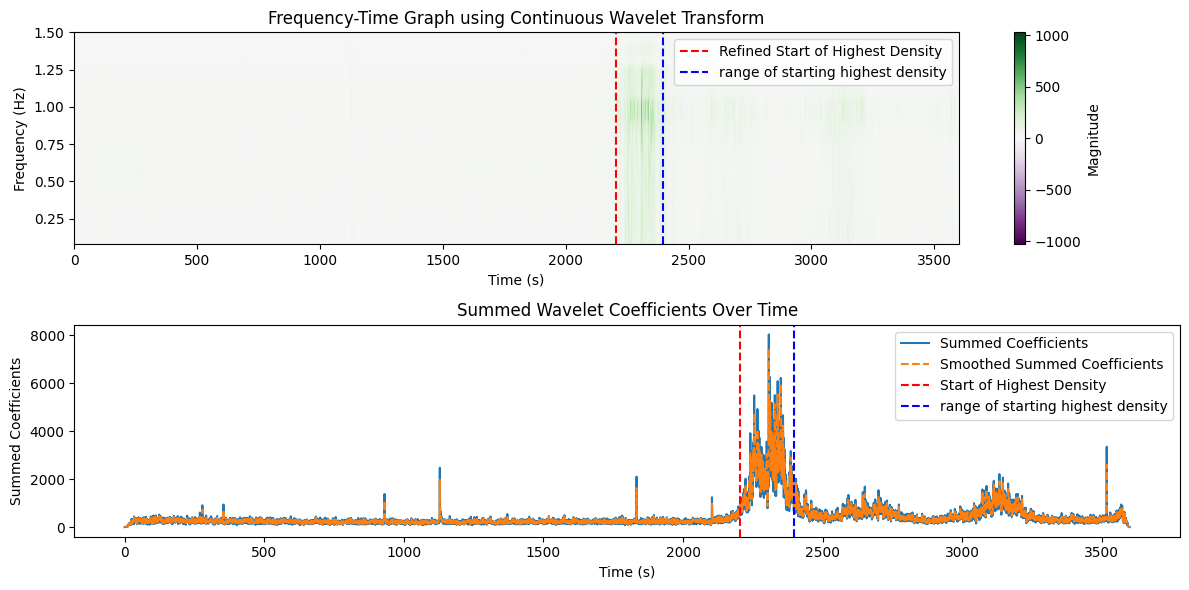

In [141]:
# Step 7: Plot the frequency-time graph
plt.figure(figsize=(12, 6))

# Plot the wavelet coefficients
plt.subplot(2, 1, 1)
plt.imshow(np.abs(coefficients), extent=[tr_times_filt[0], tr_times_filt[-1], frequencies[-1], frequencies[0]], cmap='PRGn', aspect='auto',
           vmax=abs(coefficients).max(), vmin=-abs(coefficients).max())
plt.colorbar(label='Magnitude')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')
plt.title('Frequency-Time Graph using Continuous Wavelet Transform')
plt.axvline(x=refined_start_time, color='r', linestyle='--', label='Refined Start of Highest Density')
plt.axvline(x=max_density_time_end, color='b', linestyle='--', label='range of starting highest density')
plt.legend()

# Plot the summed coefficients
plt.subplot(2, 1, 2)
plt.plot(tr_times_filt, summed_coefficients, label='Summed Coefficients')
plt.plot(tr_times_filt, smoothed_summed_coefficients, label='Smoothed Summed Coefficients', linestyle='--')
plt.axvline(x=refined_start_time, color='r', linestyle='--', label='Start of Highest Density')
plt.axvline(x=max_density_time_end, color='b', linestyle='--', label='range of starting highest density')
plt.xlabel('Time (s)')
plt.ylabel('Summed Coefficients')
plt.title('Summed Wavelet Coefficients Over Time')
plt.legend()

plt.tight_layout()
plt.show()

<h3>output of detection</h3>

In [136]:
# File name and start time of trace
##filename = 'XB.ELYSE.02.BHV.2022-02-03HR08_evid0005.mseed'
base_fname = filename.split('_')[-1].split('.')[0]
evid = base_fname.split('_')[-1]
print(evid)


starttime = tr.stats.starttime.datetime
on_time = starttime + timedelta(seconds = refined_start_time)
on_time_str = datetime.strftime(on_time,'%Y-%m-%dT%H:%M:%S.%f')

print(f'filename={tr.stats.network}.{tr.stats.station}.{tr.stats.channel}.{tr.stats.starttime}_{evid}')
print('time_abs(%Y-%m-%dT%H:%M:%S.%f)=',on_time_str)
print('time_rel=',refined_start_time)
print('evid=',evid)

# # Compile dataframe of detections
# detect_df = pd.DataFrame(data = { 'time_abs(%Y-%m-%dT%H:%M:%S.%f)':detection_times, 'time_rel(sec)':refined_start_time})
# detect_df.head()

evid0002
filename=XB.ELYSE.BHV.2022-04-09T22:00:00.035000Z_evid0002
time_abs(%Y-%m-%dT%H:%M:%S.%f)= 2022-04-09T22:55:59.135000
time_rel= 3359.1
evid= evid0002


<h3><b>Save catalog in csv</h3>

In [137]:
# Create a DataFrame with the new data
new_data = pd.DataFrame({
    'filename': [f'{tr.stats.network}.{tr.stats.station}.{tr.stats.channel}.{tr.stats.starttime}_{evid}'],
    'time_abs(%Y-%m-%dT%H:%M:%S.%f)': [on_time_str],
    'time_rel(sec)': [refined_start_time],
    'evid': [evid]
})

# Load the existing CSV file
csv_file = 'Mars_InSight_training_catalog_final_dibyanshu.csv'



try:
    existing_data = pd.read_csv(csv_file)
except FileNotFoundError:
    existing_data = pd.DataFrame(columns=['filename', 'time_abs(%Y-%m-%dT%H:%M:%S.%f)', 'time_rel(sec)', 'evid'])

# Append the new data to the existing data
updated_data = pd.concat([existing_data, new_data], ignore_index=True)

# Save the updated data back to the CSV file
updated_data.to_csv(csv_file, index=False)

# Display the updated DataFrame
print(updated_data.tail())

                                             filename  \
8   XB.ELYSE.BHV.2022-05-04T23:00:00.048000Z_evid0001   
9   XB.ELYSE.BHV.2021-05-02T01:00:00.025000Z_evid0017   
10  XB.ELYSE.BHV.2019-07-26T12:00:00.010000Z_evid0...   
11  XB.ELYSE.BHV.2022-04-09T22:00:00.035000Z_evid0...   
12  XB.ELYSE.BHV.2022-04-09T22:00:00.035000Z_evid0002   

   time_abs(%Y-%m-%dT%H:%M:%S.%f)  time_rel(sec)       evid  
8      2022-05-04T23:31:29.698000        1889.65   evid0001  
9      2021-05-02T01:31:38.075000        1898.05   evid0017  
10     1970-02-07T00:44:30.608736        1141.75  evid00014  
11     1970-02-07T00:44:30.608736        3359.10  evid00014  
12     2022-04-09T22:55:59.135000        3359.10   evid0002  


<hr><b>

---



  <h2><b>STA/LTA</h2><p><b>Another way to find  seismic event start time  (2nd method )</p>

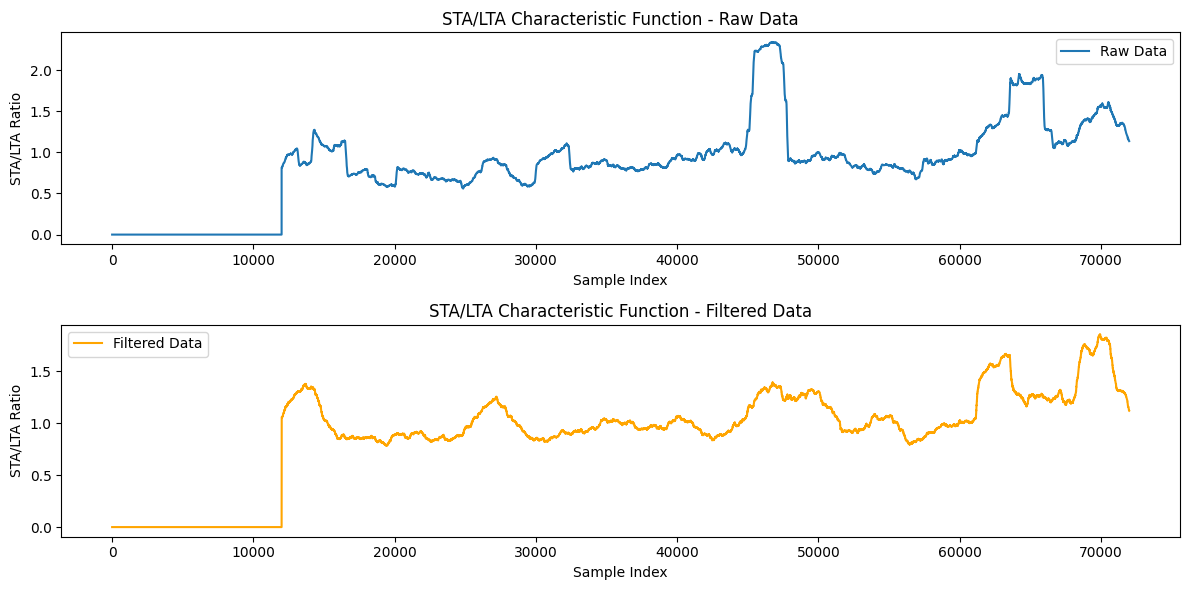

In [121]:
from obspy.signal.invsim import cosine_taper
from obspy.signal.filter import highpass
from obspy.signal.trigger import classic_sta_lta, plot_trigger, trigger_onset

# Sampling frequency of our trace
df = tr.stats.sampling_rate


sta_len = 120
lta_len = 600


# Run Obspy's STA/LTA on raw data

cft_raw = classic_sta_lta(tr_data, int(sta_len * df), int(lta_len * df))

# Run Obspy's STA/LTA on filtered data
cft_filt = classic_sta_lta(tr_data_filt,int(sta_len * df), int(lta_len * df))

# Plot the characteristic functions for comparison
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(2, 1, 1)
plt.plot(cft_raw, label='Raw Data')
plt.title('STA/LTA Characteristic Function - Raw Data')
plt.xlabel('Sample Index')
plt.ylabel('STA/LTA Ratio')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(cft_filt, label='Filtered Data', color='orange')
plt.title('STA/LTA Characteristic Function - Filtered Data')
plt.xlabel('Sample Index')
plt.ylabel('STA/LTA Ratio')
plt.legend()

plt.tight_layout()
plt.show()

Trigger

Next, we define the values of the characteristic function (i.e. amplitude ratio between short-term and long-term windows) where we flag a seismic detection. These values are called triggers. There are two types of triggers -- "on" and "off", defined as follows:

"on" : If the characteristic function is above this value, then a seismic event begins.
"off" : If the characteristic function falls below this value (after an "on" trigger), than a seismic event ends

Raw Data Triggers: [[45870 47832]]
Filtered Data Triggers: [[13527 15261]
 [46614 51525]
 [61328 71999]]


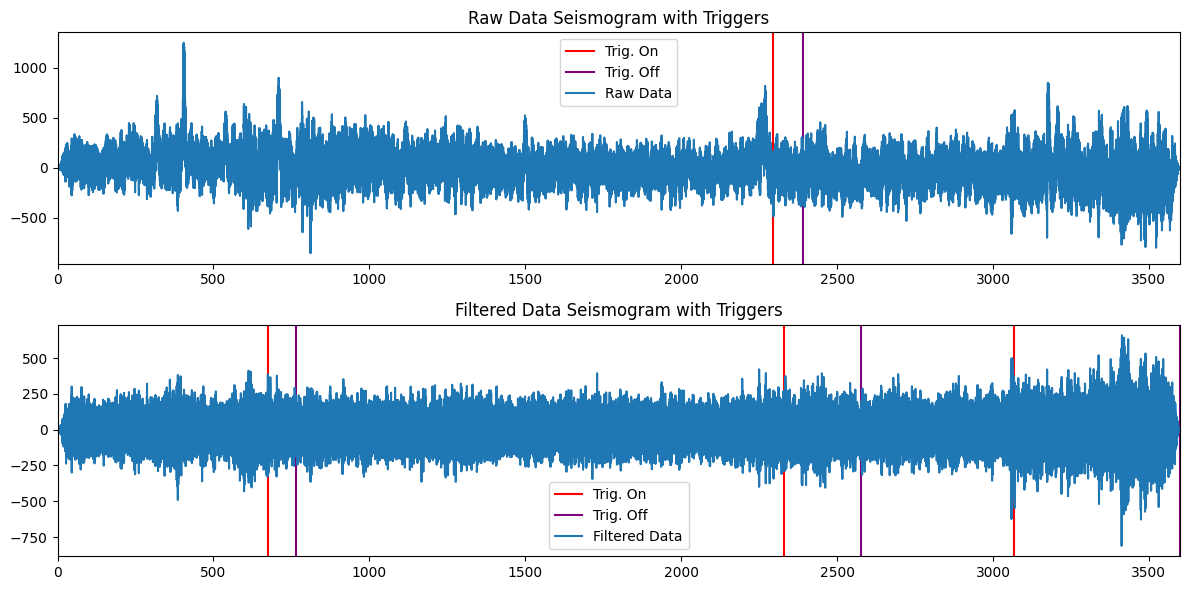

First trigger onset for raw data: 2293.5
First trigger onset for filtered data: 676.35


In [122]:
# Define trigger thresholds for raw data
thr_on_raw = max(cft_raw) - 0.09
thr_off_raw = min(cft_raw) + 1
on_off_raw = np.array(trigger_onset(cft_raw, thr_on_raw, thr_off_raw))
print("Raw Data Triggers:", on_off_raw)

# Define trigger thresholds for filtered data
thr_on_filt = max(cft_filt) - 0.5
thr_off_filt = min(cft_filt) + 1
on_off_filt = np.array(trigger_onset(cft_filt, thr_on_filt, thr_off_filt))
print("Filtered Data Triggers:", on_off_filt)

# Plot triggers and seismogram for raw data
fig, ax = plt.subplots(2, 1, figsize=(12, 6))

# Plot raw data triggers
for i in np.arange(0, len(on_off_raw)):
    triggers = on_off_raw[i]
    ax[0].axvline(x=tr_times[triggers[0]], color='red', label='Trig. On' if i == 0 else "")
    ax[0].axvline(x=tr_times[triggers[1]], color='purple', label='Trig. Off' if i == 0 else "")

# Plot raw data seismogram
ax[0].plot(tr_times, tr_data, label='Raw Data')
ax[0].set_xlim([min(tr_times), max(tr_times)])
ax[0].legend()
ax[0].set_title('Raw Data Seismogram with Triggers')

# Plot filtered data triggers
for i in np.arange(0, len(on_off_filt)):
    triggers = on_off_filt[i]
    ax[1].axvline(x=tr_times[triggers[0]], color='red', label='Trig. On' if i == 0 else "")
    ax[1].axvline(x=tr_times[triggers[1]], color='purple', label='Trig. Off' if i == 0 else "")

# Plot filtered data seismogram
ax[1].plot(tr_times, tr_data_filt, label='Filtered Data')
ax[1].set_xlim([min(tr_times), max(tr_times)])
ax[1].legend()
ax[1].set_title('Filtered Data Seismogram with Triggers')

plt.tight_layout()
plt.show()


# Print the first trigger onset for both raw and filtered data
print("First trigger onset for raw data:", tr_times[on_off_raw[0][0]])
print("First trigger onset for filtered data:", tr_times[on_off_filt[0][0]])

<h3><b>Spectrogram visualization of signals</h3>

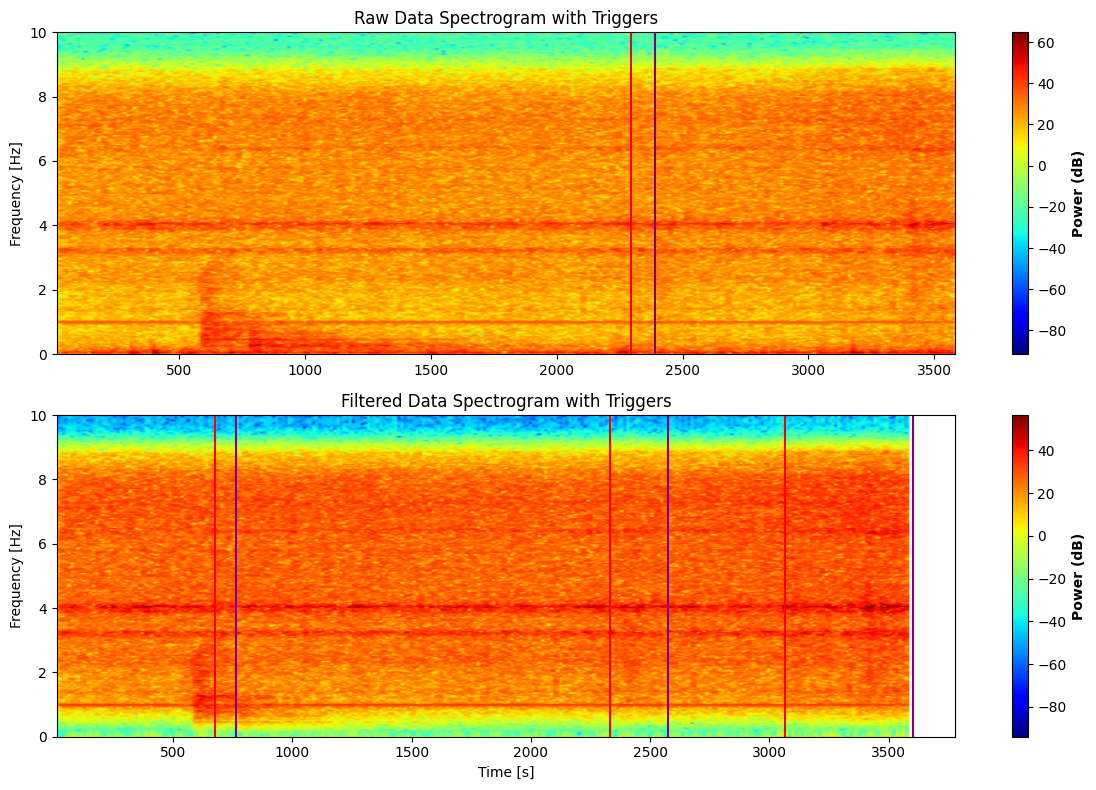

(257, 280)

In [123]:

# Compute and plot spectrogram for raw data
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
df = tr.stats.sampling_rate
f_raw, t_raw, Sxx_raw = signal.spectrogram(tr_data, df, nperseg=512, noverlap=256)
power1=ax[0].pcolormesh(t_raw, f_raw, 10 * np.log10(Sxx_raw), shading='gouraud',cmap=cm.jet)
for i in np.arange(0, len(on_off_raw)):
    triggers = on_off_raw[i]
    ax[0].axvline(x=tr_times[triggers[0]], color='red', label='Trig. On' if i == 0 else "")
    ax[0].axvline(x=tr_times[triggers[1]], color='purple', label='Trig. Off' if i == 0 else "")
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_title('Raw Data Spectrogram with Triggers')

cbar1 = plt.colorbar(power1, ax=ax[0], orientation='vertical')
cbar1.set_label('Power (dB)', fontweight='bold')

# Compute and plot spectrogram for filtered data
f_filt, t_filt, Sxx_filt = signal.spectrogram(tr_data_filt, df, nperseg=512, noverlap=256)
power2=ax[1].pcolormesh(t_filt, f_filt, 10 * np.log10(Sxx_filt), shading='gouraud',cmap=cm.jet)
for i in np.arange(0, len(on_off_filt)):
    triggers = on_off_filt[i]
    ax[1].axvline(x=tr_times[triggers[0]], color='red', label='Trig. On' if i == 0 else "")
    ax[1].axvline(x=tr_times[triggers[1]], color='purple', label='Trig. Off' if i == 0 else "")
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('Frequency [Hz]')
ax[1].set_title('Filtered Data Spectrogram with Triggers')


cbar2 = plt.colorbar(power2, ax=ax[1], orientation='vertical')
cbar2.set_label('Power (dB)', fontweight='bold')
plt.tight_layout()
plt.show()

Sxx_filt.shape #(frequcnybin, timesegment) 2D

<h3>Plot Frequency bin vs power density function</h3>

2293.5
timesegment index 178


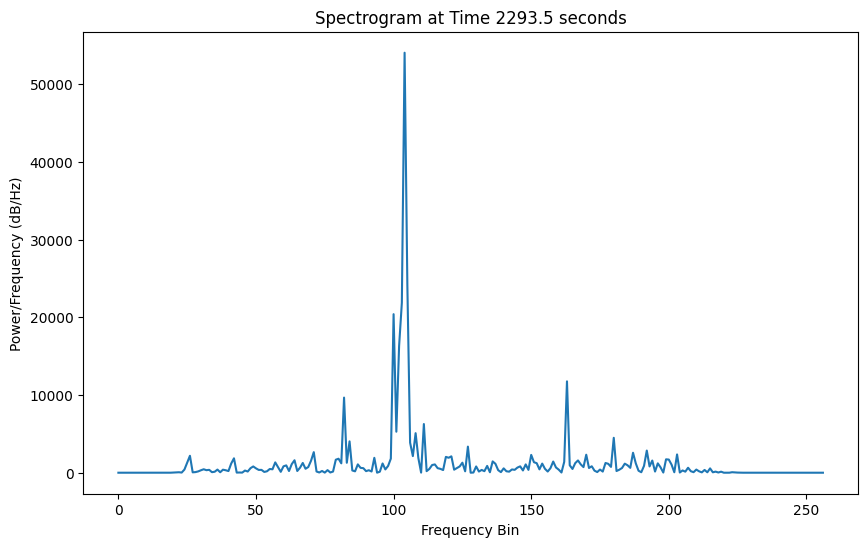

In [134]:
gt = tr_times[on_off_filt[0][0]]  # seconds
gt=2293.5
print(gt)

print( "timesegment index",np.argmin(np.abs(t_filt-gt)))


# Step 1: Find the index in the t array that is closest to the given time
time_index = np.argmin(np.abs(t_filt-gt))  #find in t[] array neared time index

# Step 2: Extract the corresponding column from the sxx array
sxx_at_given_time = Sxx_filt[:,time_index ] #here all rows belogs to that column of t value index

plt.figure(figsize=(10, 6))
plt.plot(sxx_at_given_time)
plt.xlabel('Frequency Bin')
plt.ylabel('Power/Frequency (dB/Hz)')
plt.title(f'Spectrogram at Time {gt} seconds')
plt.show()

<h3>Calculate the Frequency at higest Power density </h3>

In [135]:


print(np.argmin(np.abs(t_filt- gt)))


# Step 1: Find the index in the t array that is closest to the given time
time_index = np.argmin(np.abs(t_filt- gt))
nperseg=512
# Step 2: Extract the corresponding column from the sxx array
sxx_at_given_time = Sxx_filt[:, time_index]  # All rows belong to that column of t value index

# Step 3: Find the maximum power spectral density and its corresponding frequency bin
max_value = np.max(sxx_at_given_time)
max_bin = np.argmax(sxx_at_given_time)
print(max_bin)

# Step 4: Calculate the actual frequency for the max_bin

max_frequency = f_filt[max_bin]

#print(f"Spectral density at given time: {sxx_at_given_time}")
print(f"Maximum power spectral density: {max_value}")
print(f"Frequency bin with maximum power: {max_bin}")
print(f"Actual frequency with maximum power: {max_frequency} Hz")


frequency_resolution = df / nperseg
print(f"Frequency resolution: {frequency_resolution} Hz")

178
104
Maximum power spectral density: 54051.50749601522
Frequency bin with maximum power: 104
Actual frequency with maximum power: 4.0625 Hz
Frequency resolution: 0.0390625 Hz
